In [1]:
#Importando Bibliotecas
import pandas as pd
import numpy as np
import pickle
import warnings
import os
warnings.filterwarnings("ignore")

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

# Modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn import tree

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#Avaliação do Modelo
from sklearn.metrics import classification_report

path = input('Por favor adicione o diretorio de trabalho?')
for dirname, _, filename in os.walk(path, topdown = True):
    for filename in filename:
        if filename == 'test.csv':
                teste = pd.read_csv(os.path.join(dirname,filename))
        else:
            if filename == 'train.csv':
                treino = pd.read_csv(os.path.join(dirname,filename))
            else:
                print("Deu ruim irmão!!")
                
X = treino.drop(['Cover_Type','Id','Unnamed: 0'],axis=1) 
y= treino.Cover_Type
test_ids = teste['Id']
teste.drop(['Id','Unnamed: 0'],axis=1,inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Por favor adicione o diretorio de trabalho? C:\github\Kaggle_Challenges\Machine_Learning_Competitions\data


# Visualizando a copa da arvore.

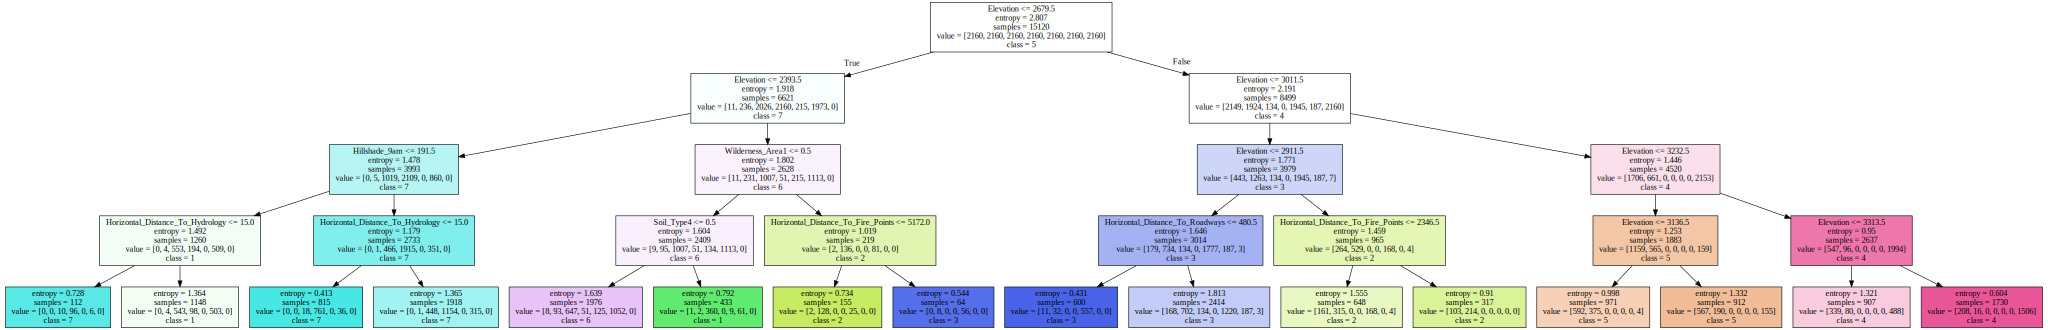

In [2]:
#X = treino.drop('Cover_Type',axis=1) 
#y= treino.Cover_Type
labels = teste.columns.values

estimator = DecisionTreeClassifier(criterion = 'entropy',
                                   max_depth = 4
                                   , min_samples_split= 2
                                   , min_samples_leaf=2)
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=list(y.unique().astype('str'))
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [3]:
def random_RF(X,y,X_teste,n_iter,ids):
    
    print('> Procurando os melhores parametros...')
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt','log2']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    criterion = ['gini','entropy']
    min_samples_split = [2, 5, 10, 12]
    min_samples_leaf = [1, 2, 4, 6, 8]
    bootstrap = [True, False]
    
    #class_weight = dict({1:3, 2:180, 3:3,4:1,5:1,6:50,7:1})
    random_grid = {'n_estimators': n_estimators,
                   'max_features':max_features,
                   'criterion': criterion,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    #class_weight = dict({1:3, 2:180, 3:3,4:1,5:1,6:50,7:1})
    random_state = 2
    rfc = RandomForestClassifier(n_jobs=-1)
    rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                                   n_iter = n_iter, cv = 5, verbose=1, random_state=random_state, 
                                   n_jobs = -1, scoring = {'NLL':'neg_log_loss', 'Accuracy':'accuracy'}, 
                                   refit='NLL')

    # Fit the random search model
    print('> Fitting Modelo...')
    rf_random.fit(X, y)
    
    
    #Submission
    print('> Criando Submission...')
    p_sub = rf_random.predict(X_teste)
    sub = pd.DataFrame(p_sub, index = ids, columns=['Cover_Type'])
    print(sub.shape)

    #Salvando em csv
    sub.to_csv('submission.csv')
    print('Arquivo salvo!')
    print('> Treinamento realizado...')
    return rf_random.best_estimator_, rf_random.cv_results_, rf_random.best_params_

In [4]:
#ids = test['Id']
trained_model, results, params=random_RF(X_train,y_train,teste,10,test_ids)

> Procurando os melhores parametros...
> Fitting Modelo...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.1min finished


> Criando Submission...
(565892, 1)
Arquivo salvo!
> Treinamento realizado...


In [10]:
params

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'criterion': 'gini',
 'bootstrap': False}

In [9]:
# Validação Cruzada
resultado_rf = []
kf = RepeatedKFold(n_splits = 2, n_repeats=10, random_state=1)

for linhas_treino_rf, linhas_valid_rf in kf.split(X_train):

    X_treino_rf, X_valid_rf = X_train.iloc[linhas_treino_rf], X_train.iloc[linhas_valid_rf]
    y_treino_rf, y_valid_rf = y_train.iloc[linhas_treino_rf], y_train.iloc[linhas_valid_rf]
    
    
    trained_model.fit(X_treino_rf,y_treino_rf)
    p_rf= trained_model.predict(X_valid_rf)
    acc_rf = np.mean(y_valid_rf==p_rf)
    resultado_rf.append(acc_rf)
print(np.mean(resultado_rf))
print(np.std(resultado_rf))
print(classification_report(y_valid_rf,p_rf))

0.821329365079365
0.004199995825782674
              precision    recall  f1-score   support

           1       0.76      0.71      0.73       862
           2       0.72      0.67      0.69       841
           3       0.83      0.75      0.79       905
           4       0.92      0.95      0.94       855
           5       0.85      0.91      0.88       876
           6       0.76      0.85      0.80       828
           7       0.92      0.94      0.93       881

    accuracy                           0.82      6048
   macro avg       0.82      0.82      0.82      6048
weighted avg       0.82      0.82      0.82      6048



In [ ]:
#Feature Selection - Random Forest

cols = X.columns.values
importances = trained_model.feature_importances_
var = {a:b for (a,b) in zip(cols,importances)}

df_var = pd.DataFrame(var,index = var.keys())
df_var.reset_index(inplace = True)
df_var.drop('index',axis=1, inplace = True)
df_var = df_var.iloc[:1,0:]
df_var = df_var.melt().sort_values('value', ascending = False)

print('Top 10 variáveis')
print(df_var.head(20))
print('\n')